In [13]:
import os
import boto3
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

True

In [3]:
# Custom function to reduce memory usage of data

def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

In [7]:
s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key="processed/tcga_processed.csv")

status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 get_object response. Status - {status}")
    df = reduce_mem_usage(pd.read_csv(response.get("Body")))
    print(df.info())
else:
    print(f"Unsuccessful S3 get_object response. Status - {status}")

Successful S3 get_object response. Status - 200
Mem. usage decreased to  0.61 Mb (86.1% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10954 entries, 0 to 10953
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Primary_Site                    10954 non-null  int8   
 1   Deceased_Status                 10954 non-null  int8   
 2   Age_At_Diagnosis                10870 non-null  float32
 3   Prior_Malignancy                10954 non-null  int8   
 4   Synchronous_Malignancy          10954 non-null  int8   
 5   TP53                            10954 non-null  int8   
 6   PIK3CA                          10954 non-null  int8   
 7   TTN                             10954 non-null  int8   
 8   CDH1                            10954 non-null  int8   
 9   GATA3                           10954 non-null  int8   
 10  APC                             10954 non-null  int8   

In [10]:
final_df = df.drop('Weight', axis=1)

In [11]:
final_df.head()

,Primary_Site,Deceased_Status,Age_At_Diagnosis,Prior_Malignancy,Synchronous_Malignancy,TP53,PIK3CA,TTN,CDH1,GATA3,...,MET,KMT2C,PKHD1,ICE1,SMAD4,CDKN2A,Race_asian,Race_black or african american,Race_other,Race_white
0,0,0,9.602739,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,6.375342,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,16.753426,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,16.038357,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,14.052054,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
final_df.shape

(10954, 51)

## Distribution of target classes

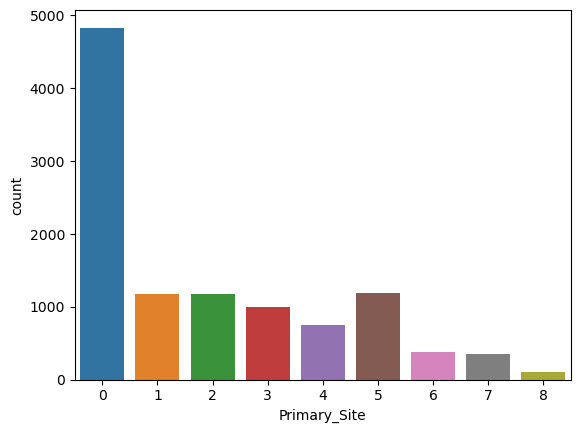

In [23]:
sns.countplot(data = final_df, x = 'Primary_Site')
plt.show()

As demonstrated in the plot above, the classes have a severe imbalance problem, especially for class 0 which pertains to Myeloid cancers. Therefore, the weight column is used to address the imbalance in the model.

## Distributions of target classes by age at diagnosis

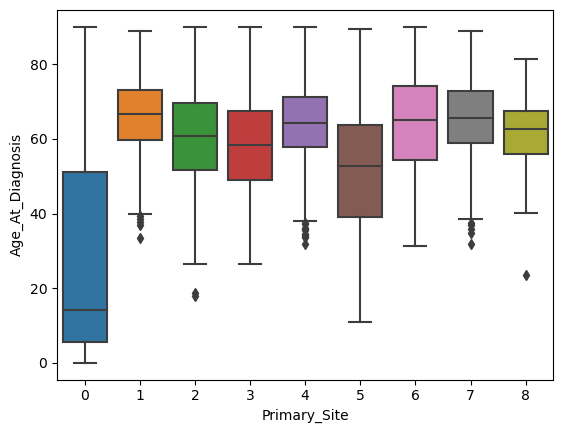

In [25]:
sns.boxplot(data = final_df, x = 'Primary_Site', y='Age_At_Diagnosis')
plt.show()

## Correlation heat map for multicollinearity

In [15]:
final_df.corr()

,Primary_Site,Deceased_Status,Age_At_Diagnosis,Prior_Malignancy,Synchronous_Malignancy,TP53,PIK3CA,TTN,CDH1,GATA3,...,MET,KMT2C,PKHD1,ICE1,SMAD4,CDKN2A,Race_asian,Race_black or african american,Race_other,Race_white
Primary_Site,1.000000,0.338478,0.479423,0.057889,-0.003365,0.378219,0.238107,0.200877,0.080727,0.069821,...,0.050837,0.103198,0.070102,0.048564,0.166242,0.117977,0.008245,-0.017659,0.109147,-0.035794
Deceased_Status,0.338478,1.000000,0.284419,0.046571,-0.013733,0.163171,-0.002387,0.093043,-0.018546,-0.004156,...,0.002961,0.013617,0.039522,0.013629,0.045674,0.080343,-0.017695,-0.048449,0.022158,0.039573
Age_At_Diagnosis,0.479423,0.284419,1.000000,0.167137,0.034136,0.305158,0.191490,0.328751,0.085939,0.072404,...,0.075854,0.142773,0.148444,0.102758,0.104305,0.104311,-0.016377,-0.003202,0.038691,-0.004286
Prior_Malignancy,0.057889,0.046571,0.167137,1.000000,-0.011007,0.065403,0.041322,0.074167,0.042102,0.008145,...,0.025037,0.018787,0.051602,0.032369,0.023931,0.020999,-0.033191,0.016525,-0.033948,0.019742
Synchronous_Malignancy,-0.003365,-0.013733,0.034136,-0.011007,1.000000,0.009283,-0.016380,0.025152,0.005253,0.016656,...,-0.006313,0.005115,-0.004090,-0.007909,-0.007114,0.003536,-0.012740,0.045777,-0.009036,-0.025565
TP53,0.378219,0.163171,0.305158,0.065403,0.009283,1.000000,0.093469,0.333741,-0.008769,0.029551,...,0.023220,0.078996,0.153386,0.108838,0.108551,0.189793,0.062709,0.010731,0.048553,-0.064343
PIK3CA,0.238107,-0.002387,0.191490,0.041322,-0.016380,0.093469,1.000000,0.148457,0.175171,0.073135,...,0.053423,0.152507,0.072205,0.063958,0.041788,0.006850,-0.003308,0.012343,0.016388,-0.014762
TTN,0.200877,0.093043,0.328751,0.074167,0.025152,0.333741,0.148457,1.000000,0.078950,0.090911,...,0.114374,0.209606,0.262684,0.217150,0.102782,0.141984,0.009987,-0.003498,0.028515,-0.014697
CDH1,0.080727,-0.018546,0.085939,0.042102,0.005253,-0.008769,0.175171,0.078950,1.000000,0.073842,...,0.019651,0.081588,0.053142,0.046797,0.034854,0.007738,-0.007639,0.004273,-0.010171,0.005145
GATA3,0.069821,-0.004156,0.072404,0.008145,0.016656,0.029551,0.073135,0.090911,0.073842,1.000000,...,0.051937,0.073105,0.042646,0.043529,0.006771,0.023901,0.010781,0.017194,-0.003463,-0.018427


Text(0.5, 1.0, 'Correlation Heatmap')

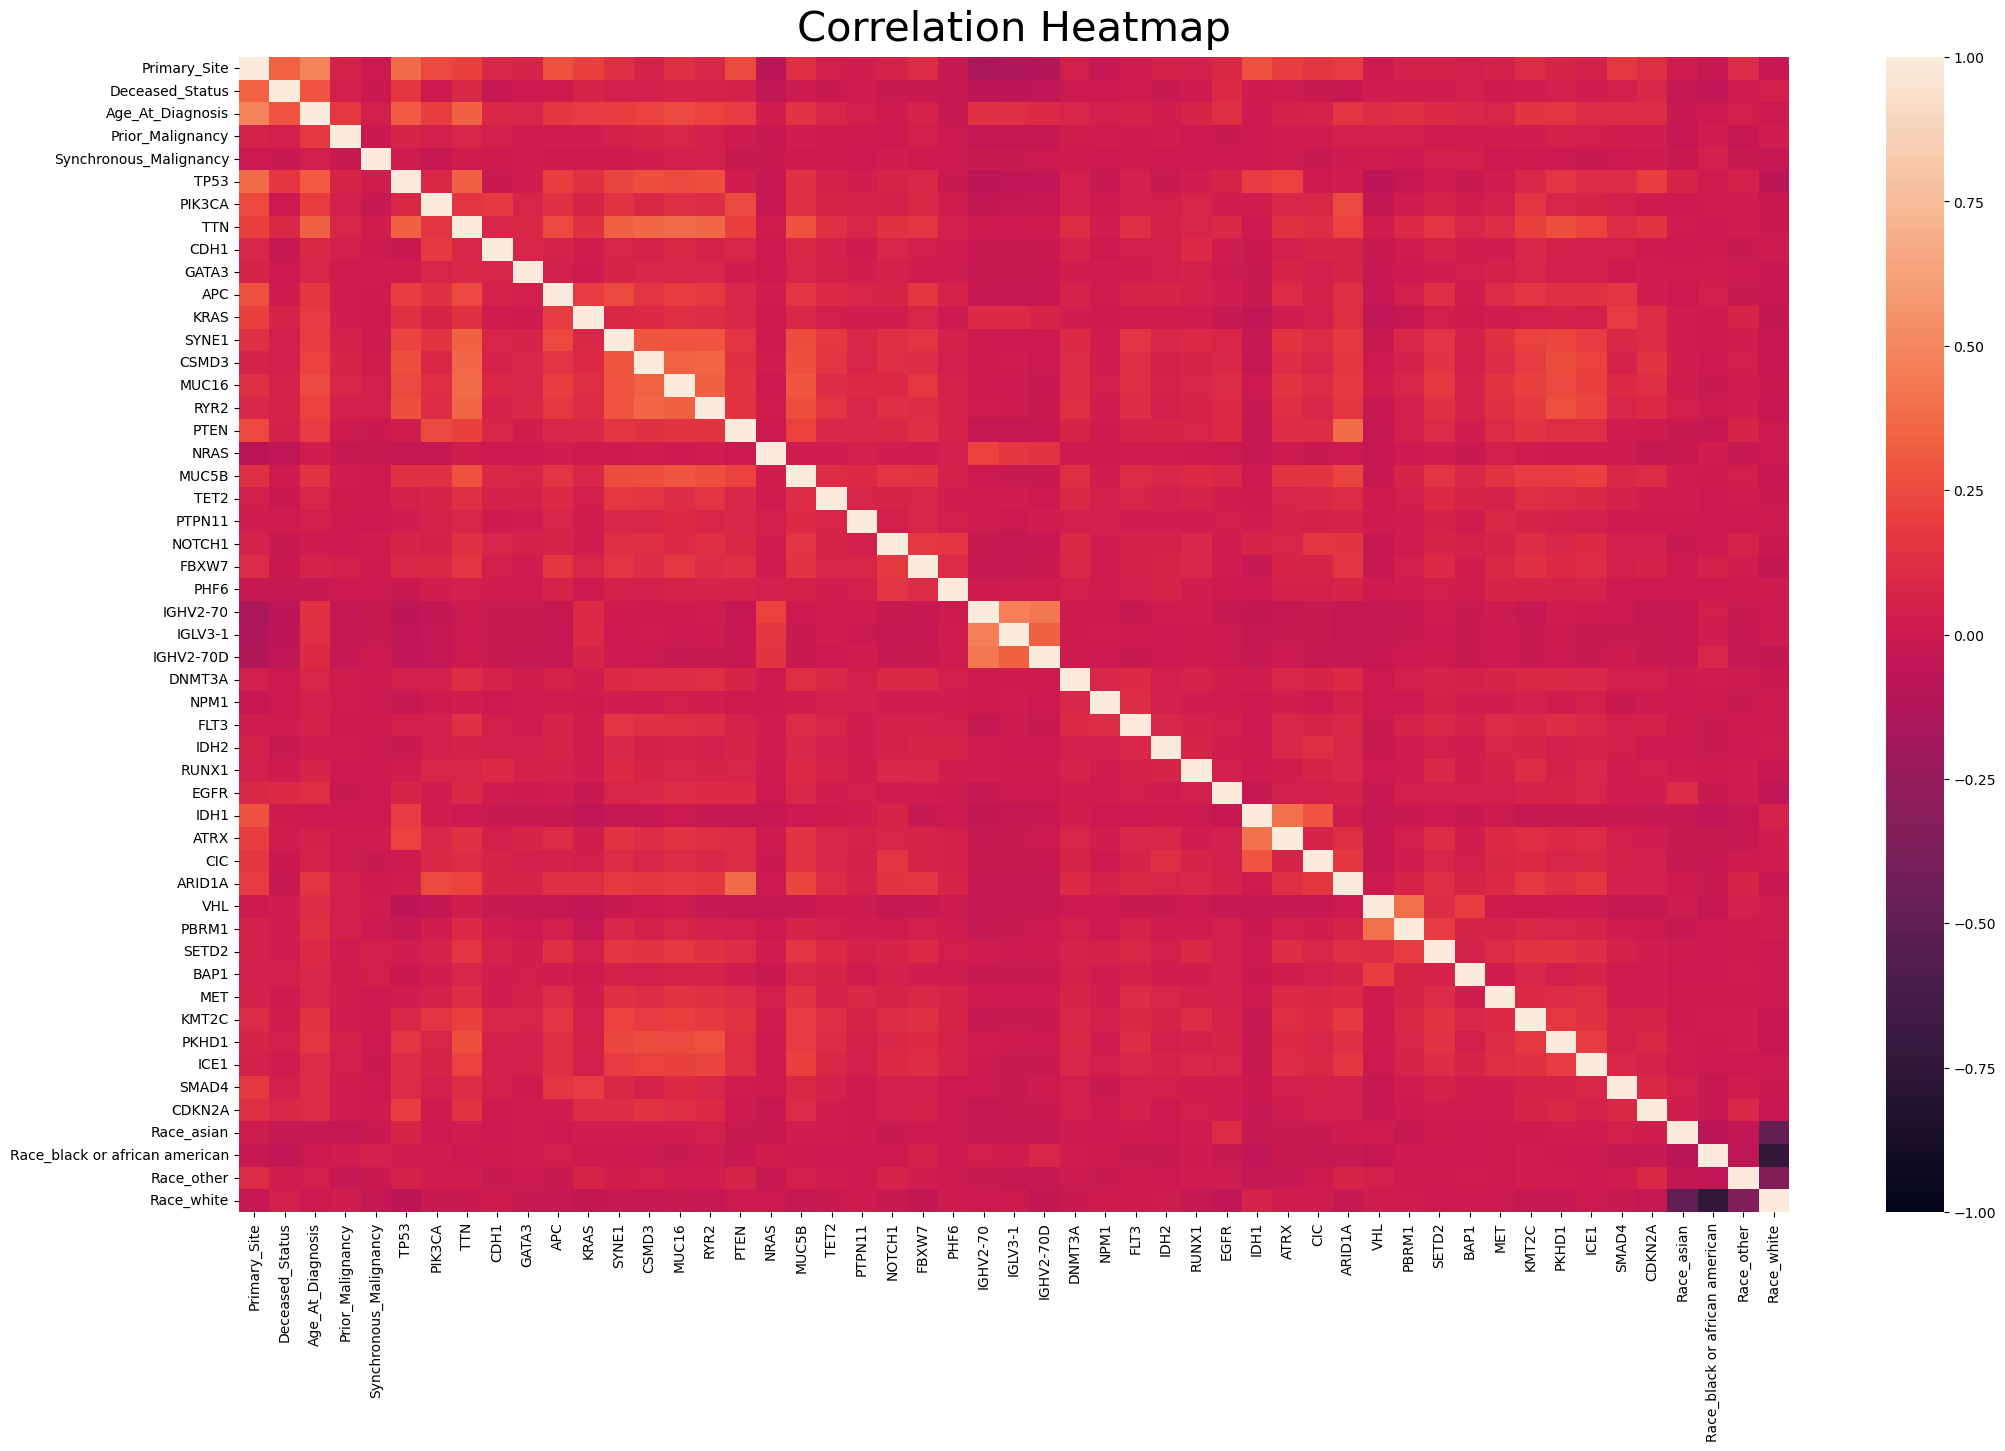

In [20]:
plt.figure(figsize=(25,15))
heatmap = sns.heatmap(final_df.corr(), vmin=-1, vmax=1, annot=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=12)

As illustrated above, the only features that exceed |0.70| in correlation are race_white and race_black, since they represented the majority of the cases' races.

## Distribution of races and ethnicities

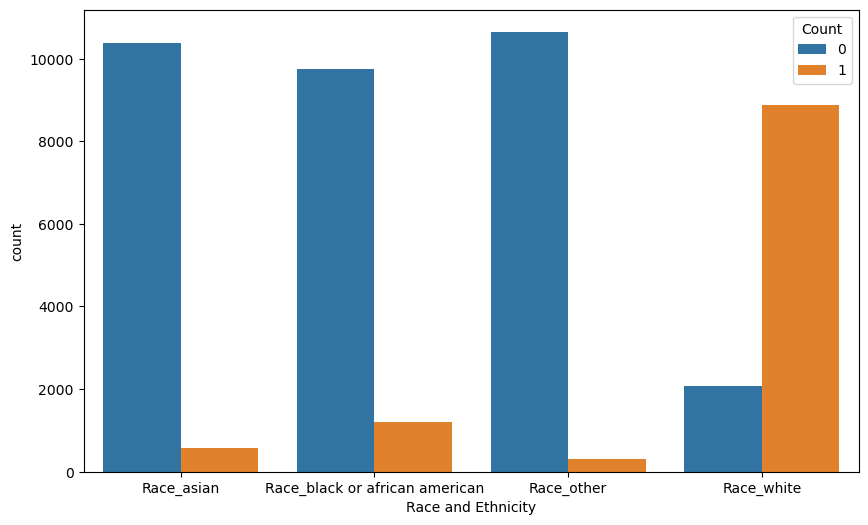

In [42]:
plt.figure(figsize=(10,6))

race_df = final_df[['Race_asian', 'Race_black or african american', 'Race_other', 'Race_white']]
race_df1 = race_df.melt(var_name='Race and Ethnicity', value_name='Count')
sns.countplot(x='Race and Ethnicity', hue='Count', data=race_df1)

plt.show()